In [1]:
# Import Packages
import matplotlib as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import tensorflow.keras

In [2]:
# Load Training and Testing Data from Files
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")
print(x_train[1,1:100,0:15])
print(y_train)
save_path = f'C:\\Users\\Kabajisan\\Documents\\NSF Training\\Day1\\Saves'

[[  0.9617   0.993    1.0109 ... 376.9911 376.9911 376.9911]
 [  0.9617   0.993    1.0109 ... 376.9911 376.9911 376.9911]
 [  0.9617   0.993    1.0109 ... 376.9911 376.9911 376.9911]
 ...
 [  0.9578   0.9936   1.0145 ... 376.9911 376.9911 376.9911]
 [  0.9578   0.9936   1.0145 ... 376.9911 376.9911 376.9911]
 [  0.9578   0.9936   1.0145 ... 376.9911 376.9911 376.9911]]
[[0 1 1]
 [0 0 1]
 [1 0 0]
 ...
 [0 1 1]
 [1 0 0]
 [0 1 0]]


In [3]:
# Verify Data
print('dataset: X_train:', x_train.shape, 'Y_train:', y_train.shape, 'X_test:', x_test.shape, 'Y_test', y_test.shape)

dataset: X_train: (2010, 100, 16) Y_train: (2010, 3) X_test: (990, 100, 16) Y_test (990, 3)


In [4]:
# Import Packages for Models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Activation, Add, AveragePooling1D
from tensorflow.keras.layers import MaxPool1D

In [5]:
# Set Input Shape and Output Size
input_shape = x_train.shape[1:]
num_class = 3

In [6]:
# inception model
from tensorflow.keras.layers import Concatenate

# Function Creates an Inception Module
def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, bottleneck_size=32,
                      kernel_size=40, nb_filters=32):
    if use_bottleneck and int(input_tensor.shape[-1]) > bottleneck_size:
        input_inception = Conv1D(filters=bottleneck_size, kernel_size=1,
                                 padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
    conv_list = []
    for i in range(len(kernel_size_s)):
        conv_list.append(Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i], strides=stride, padding='same',
                                activation=activation, use_bias=False)(input_inception))
    max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)
    conv_6 = Conv1D(filters=nb_filters, kernel_size=1, padding='same',
                    activation=activation, use_bias=False)(max_pool_1)
    conv_list.append(conv_6)
    x = Concatenate(axis=2)(conv_list)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    return x

# Function Creates Inception Shortcut Layer
def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1, padding='same', use_bias=False)(input_tensor)
    shortcut_y = BatchNormalization()(shortcut_y)
    x = Add()([shortcut_y, out_tensor])
    x = Activation('relu')(x)
    return x

# Function Creates Entire Inception Network Using Modules and Shortcut Layer
def generate_inception(INPUT_SHAPE, NB_CLASS, use_residual=True, depth=6):
    input_layer = Input(INPUT_SHAPE)
    x = input_layer
    input_res = input_layer
    for d in range(depth):
        x = _inception_module(x)
        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x
    gap_layer = GlobalAveragePooling1D()(x)
    output_layer = Dense(NB_CLASS, activation='sigmoid')(gap_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define Inception Model
inception_model = generate_inception(input_shape, num_class)

In [7]:
#ResNet Model
def generate_resnet(INPUT_SHAPE, NB_CLASS):
    n_feature_maps = 32
    input_layer = Input(INPUT_SHAPE)
    # BLOCK 1
    conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # expand channels for the sum
    shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = BatchNormalization()(shortcut_y)
    output_block_1 = Add()([shortcut_y, conv_z])
    output_block_1 = Activation('relu')(output_block_1)
    # BLOCK 2
    conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # expand channels for the sum
    shortcut_y = Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = BatchNormalization()(shortcut_y)
    output_block_2 = Add()([shortcut_y, conv_z])
    output_block_2 = Activation('relu')(output_block_2)
    # BLOCK 3
    conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('relu')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # no need to expand channels because they are equal
    shortcut_y = BatchNormalization()(output_block_2)
    output_block_3 = Add()([shortcut_y, conv_z])
    output_block_3 = Activation('relu')(output_block_3)
    # FINAL
    gap_layer = GlobalAveragePooling1D()(output_block_3)
    output_layer = Dense(NB_CLASS, activation='sigmoid')(gap_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define Inception Model
resnet_model = generate_resnet(input_shape, num_class)

In [8]:
#Best Threshold Calculator for Changing Nonbinary Output labels to Binary

from sklearn.metrics import matthews_corrcoef


def threshold_calibration_matthews_corrcoef(LABEL, SCORE):
    Pred = SCORE
    Truth = LABEL
    threshold = np.arange(0.1, 0.9, 0.1)
    acc = []
    accuracies = []
    best_threshold = np.zeros(Pred.shape[1])
    for i in range(Pred.shape[1]):
        y_prob = np.array(Pred[:, i])
        for j in threshold:
            y_pred = [1 if prob >= j else 0 for prob in y_prob]
            acc.append(matthews_corrcoef(Truth[:, i], y_pred))
        acc = np.array(acc)
        index = np.where(acc == acc.max())
        accuracies.append(acc.max())
        best_threshold[i] = threshold[index[0][0]]
        acc = []

    return best_threshold


In [9]:
# Import Training Optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [10]:
# Set Inception Training Parameters (can change batch size, number epochs, learning rate)
batch_size = 4
num_epoch = 1
learning_rate = .0001
mini_batch_size = int(min(x_train.shape[0]/10, batch_size))
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
optm = Adam(lr=learning_rate)

C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
#START Inception Training
seq = inception_model
seq.compile(optimizer=optm, loss='binary_crossentropy', metrics=['accuracy'])
history = seq.fit(x_train, y_train,
                  batch_size=mini_batch_size,
                  epochs=num_epoch,
                  shuffle=True,
                  verbose=1,
                  validation_split=0.0,
                  validation_data=(x_train, y_train),
                  callbacks=[reduce_lr_loss])

503/503 [==============================] - 64s 99ms/step - loss: 0.4362 - accuracy: 0.6796 - val_loss: 24.8994 - val_accuracy: 0.2796


C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classificat

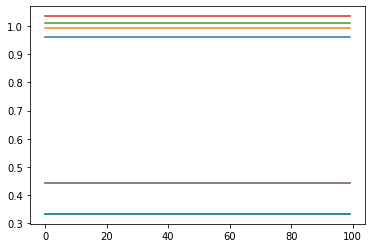


[0 1 1]
[1 0 0]


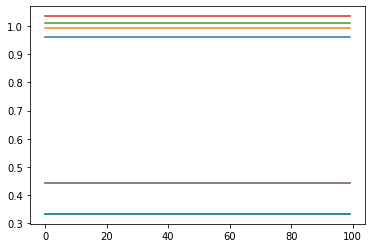


[0 1 1]
[0 1 1]


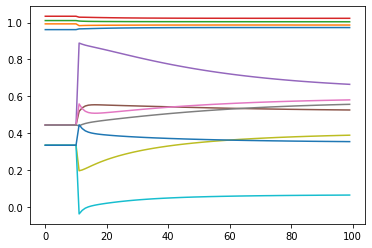


[0 1 1]
[0 0 1]


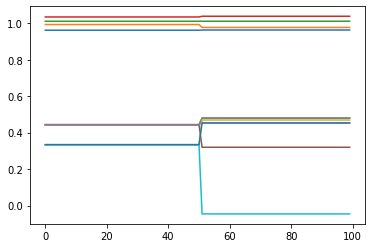


[0 1 1]
[0 0 1]


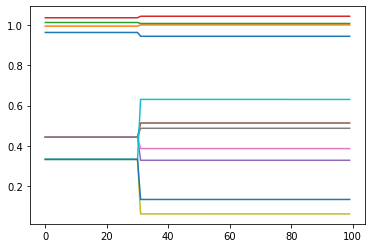


[0 1 1]
[0 0 1]


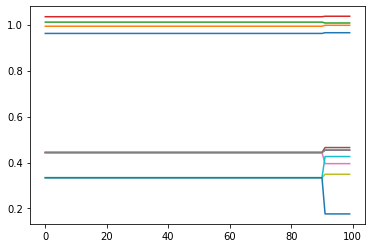


[0 1 1]
[1 0 0]


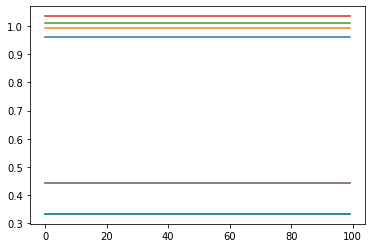


[0 1 1]
[0 0 1]


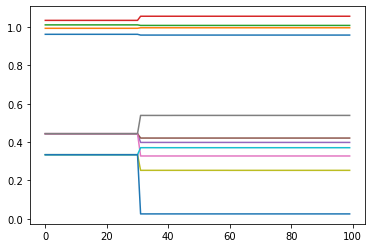


[0 1 1]
[1 0 0]


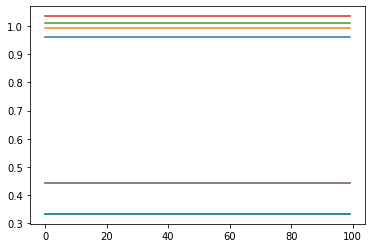


[0 1 1]
[0 1 1]


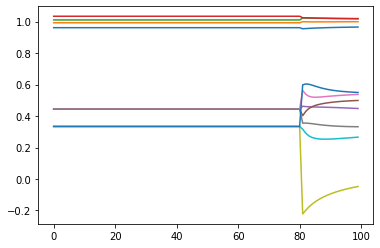


[0 1 1]
[0 1 1]


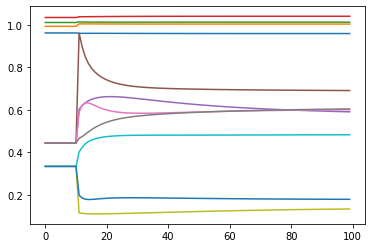


[0 1 1]
[0 1 0]


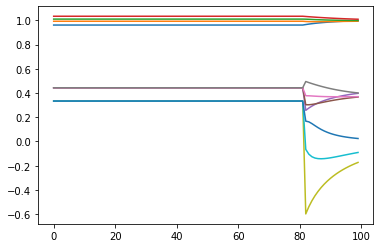


[0 1 1]
[0 1 0]


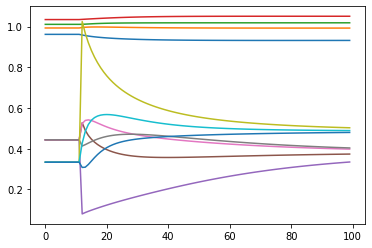


[0 1 1]
[0 1 0]


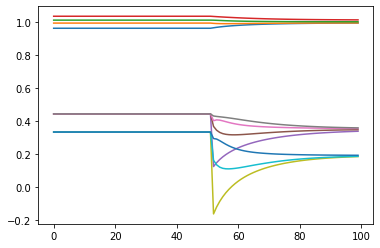


[0 1 1]
[1 0 0]


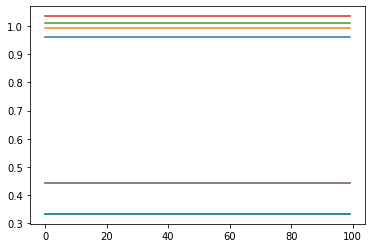


[0 1 1]
[0 0 1]


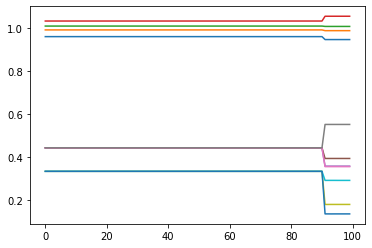


[0 1 1]
[0 1 1]


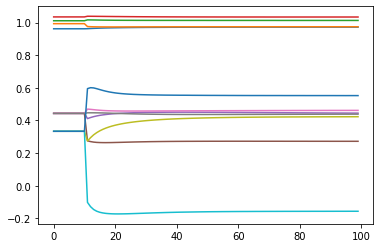


[0 1 1]
[0 1 1]


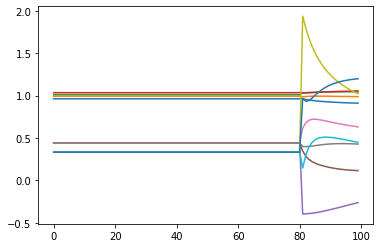


[0 1 1]
[0 1 1]


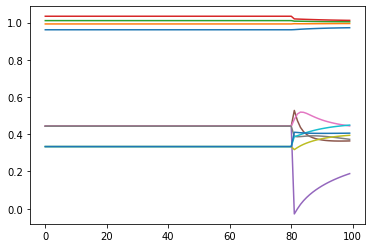


[0 1 1]
[0 0 1]


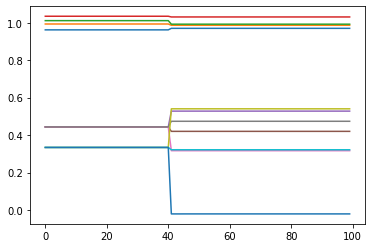


F1_score(Micro): 0.6726044226044225
F1_score(Macro): 0.474748713991552
presicion Score(Micro): 0.553030303030303
presicion Score(Macro): 0.3686868686868687
recall Score(Micro): 0.8581504702194357
recall Score(Macro): 0.6666666666666666
Acc_score: 0.2909090909090909
[[[809   0]
  [181   0]]

 [[  0 431]
  [  0 559]]

 [[  0 454]
  [  0 536]]]
Acc_score Normal: 0.8171717171717172
Acc_score Load Change: 0.5646464646464646
Acc_score Attack: 0.5414141414141415
C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Inception Transform Predictions from Non-binary to Binary
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix, confusion_matrix
y_pred = inception_model.predict(x_test)
best_threshold = threshold_calibration_matthews_corrcoef(LABEL=y_train, SCORE=inception_model.predict(x_train))
y_pred_binary = np.array(
    [[1 if y_pred[i, j] >= best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

# Graph first 's' Samples and Predictions
s = 20
for i in range (s):
    print(y_pred_binary[i])  
    print(y_test[i]) 
    plt.pyplot.plot(x_test[i,:,0:15])
    plt.pyplot.show() 
    print()

# Inception Performance
print('F1_score(Micro):', f1_score(y_test, y_pred_binary, average='micro'))
print('F1_score(Macro):', f1_score(y_test, y_pred_binary, average='macro'))
print('presicion Score(Micro):', precision_score(y_test, y_pred_binary, average='micro'))
print('presicion Score(Macro):', precision_score(y_test, y_pred_binary, average='macro'))
print('recall Score(Micro):', recall_score(y_test, y_pred_binary, average='micro'))
print('recall Score(Macro):', recall_score(y_test, y_pred_binary, average='macro'))
print('Acc_score:', accuracy_score(y_test, y_pred_binary))
print(multilabel_confusion_matrix(y_test, y_pred_binary))
print('Acc_score Normal:', accuracy_score(y_test[:,0], y_pred_binary[:,0]))
print('Acc_score Load Change:', accuracy_score(y_test[:,1], y_pred_binary[:,1]))
print('Acc_score Attack:', accuracy_score(y_test[:,2], y_pred_binary[:,2]))

In [ ]:
# Save Metrics in dictionaries
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [ ]:
# Plot ROC Curves for Multilabel Inception
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as pyplt

# First aggregate all false positive rates
n_classes = 3
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
pyplt.figure()
pyplt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

pyplt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['pink', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
      if i == 0:
            label='Normal '
      if i == 1:
            label='Load Change'
      if i == 2:
            label='Attack'
      pyplt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label=label + ' (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

pyplt.rc('font',family='Times New Roman')
pyplt.plot([0, 1], [0, 1], 'k--', lw=lw)
pyplt.xlim([0.0, 1.0])
pyplt.ylim([0.0, 1.05])
pyplt.xlabel('False Positive Rate', font='Times New Roman', fontsize=20)
pyplt.ylabel('True Positive Rate', font='Times New Roman', fontsize=20)
pyplt.title('Inception ROC')
pyplt.legend(loc="lower right")
pyplt.legend(fontsize=15.5)
pyplt.show()

In [ ]:
# Set ResNet Training Parameters (can change batch size, number epochs, learning rate)
batch_size = 8
num_epoch = 25
learning_rate = .00001
mini_batch_size = int(min(x_train.shape[0]/10, batch_size))
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
optm = Adam(lr=learning_rate)

In [ ]:
# START ResNet Training
seq = resnet_model
seq.compile(optimizer=optm, loss='binary_crossentropy', metrics=['accuracy'])
history = seq.fit(x_train, y_train,
                  batch_size=mini_batch_size,
                  epochs=num_epoch,
                  shuffle=True,
                  verbose=1,
                  validation_split=0.0,
                  validation_data=(x_train, y_train),
                  callbacks=[reduce_lr_loss])
seq.save(save_path)

In [ ]:
# ResNet Transform Predictions from Non-binary to Binary
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
y_pred = resnet_model.predict(x_test)
best_threshold = threshold_calibration_matthews_corrcoef(LABEL=y_train, SCORE=resnet_model.predict(x_train))
y_pred_binary = np.array(
    [[1 if y_pred[i, j] >= best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

# Graph first 's' Samples and Predictions
s =20
for i in range(0,s):
    print(y_pred_binary[i])  
    print(y_test[i]) 
    plt.pyplot.plot(x_test[i,:,0:11])
    plt.pyplot.show() 
    print()

# \Resnet Performance
print('F1_score(Micro):', f1_score(y_test, y_pred_binary, average='micro'))
print('F1_score(Macro):', f1_score(y_test, y_pred_binary, average='macro'))
print('presicion Score(Micro):', precision_score(y_test, y_pred_binary, average='micro'))
print('presicion Score(Macro):', precision_score(y_test, y_pred_binary, average='macro'))
print('recall Score(Micro):', recall_score(y_test, y_pred_binary, average='micro'))
print('recall Score(Macro):', recall_score(y_test, y_pred_binary, average='macro'))
print('Acc_score:', accuracy_score(y_test, y_pred_binary))
print(multilabel_confusion_matrix(y_test, y_pred_binary))
print('Acc_score Normal:', accuracy_score(y_test[:,0], y_pred_binary[:,0]))
print('Acc_score Load Change:', accuracy_score(y_test[:,1], y_pred_binary[:,1]))
print('Acc_score Attack:', accuracy_score(y_test[:,2], y_pred_binary[:,2]))

In [ ]:
# Save Metrics in dictionaries
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


In [ ]:
# Plot ROC Curves for Multilabel ResNet

# First aggregate all false positive rates
n_classes = 3
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
pyplt.figure()
pyplt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

pyplt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['pink', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
      if i == 0:
            label='Normal '
      if i == 1:
            label='Load Change'
      if i == 2:
            label='Attack'
      pyplt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label=label + ' (area = {1:0.2f})'
            ''.format(i, roc_auc[i]))

pyplt.rc('font',family='Times New Roman')
pyplt.plot([0, 1], [0, 1], 'k--', lw=lw)
pyplt.xlim([0.0, 1.0])
pyplt.ylim([0.0, 1.05])
pyplt.xlabel('False Positive Rate', font='Times New Roman', fontsize=20)
pyplt.ylabel('True Positive Rate', font='Times New Roman', fontsize=20)
pyplt.title('ResNet ROC')
pyplt.legend(loc="lower right")
pyplt.legend(fontsize=15.5)
pyplt.show()



In [14]:
f1_score_micro = f1_score(y_test, y_pred_binary, average='micro')    
f1_score_macro = f1_score(y_test, y_pred_binary, average='macro') 
ps_score_micro = precision_score(y_test, y_pred_binary, average='micro')
ps_score_macro = precision_score(y_test, y_pred_binary, average='macro')
rs_micro = recall_score(y_test, y_pred_binary, average='micro')
rs_macro = recall_score(y_test, y_pred_binary, average='macro')
acc_score = accuracy_score(y_test, y_pred_binary)
ml_conf_matrix = multilabel_confusion_matrix(y_test, y_pred_binary)
acc_score_normal = accuracy_score(y_test[:,0], y_pred_binary[:,0])
acc_score_load_change = accuracy_score(y_test[:,1], y_pred_binary[:,1])
acc_score_attack = accuracy_score(y_test[:,2], y_pred_binary[:,2])

results = {'f1_score_micro' : f1_score_micro,
            'f1_score_macro' : f1_score_macro,
            'presicion_score_micro' : ps_score_micro,
            'presicion_score_macro' : ps_score_macro,
            'rs_micro' : rs_micro,
            'rs_macro' : rs_macro,
            'acc_score' : acc_score,
            'acc_score_normal' : acc_score_normal,
            'acc_score_load_change' : acc_score_load_change,
            'acc_score_attack' : acc_score_attack}

C:\Users\Kabajisan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
df = pd.DataFrame([results])
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('results.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [21]:
file_path = f'C:\\Users\\Kabajisan\Documents\\GitHub\\investing-tools\\data\\stocks\\cat\\price_data\\2021\\05\\18.csv'
#file_name = f'{day}.csv'

def get_data_from_csv(file_path):
    dataset_train = pd.read_csv(file_path)
    training_set = dataset_train.iloc[:,2:3].values

    return training_set

def data_normalization(training_set):
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)

    return training_set_scaled

training_set = get_data_from_csv(file_path)
print(training_set)
training_set_scaled = data_normalization(training_set)
print(training_set_scaled)


IndexingError: Too many indexers